BNO frames: 8896
BNO rotation mats shape: (8896, 3, 3)
H5 files: [PosixPath('/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/aligned_predictions_with_ca_and_dF_F_wnd1000_stp700_max15_diff3.5_pnrauto.h5')]
Predicted frames: 8896
Head rotation mats shape: (8896, 3, 3)
Frame 0 pred pts:
 [[ -3.71953889 -14.63203413   0.59609063]
 [  3.71953889  14.63203413  -0.59609063]
 [ 21.25044992   2.63730421 -20.55993497]]
Frame 0 bno pts:
 [[ -3.60296932 -12.7264707    7.30357939]
 [  3.60296932  12.7264707   -7.30357939]
 [  0.89323715  -6.64324364 -28.91915233]]


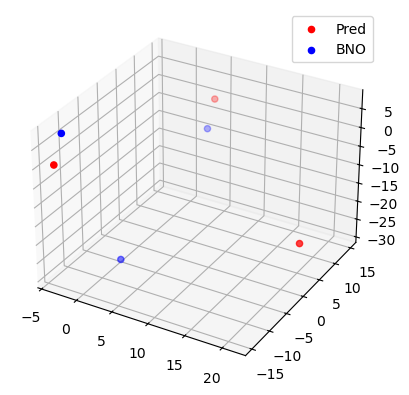

RMSD after alignment: 0.0
Alignment rotation matrix:
 [[ 0.70766193 -0.28028851 -0.64857763]
 [ 0.09487046  0.94733021 -0.30588406]
 [ 0.70015297  0.15493165  0.69698063]]
Frame 0 BNO pts after pre-rotation:
 [[  2.68237747 -12.69976901   7.73352665]
 [ -2.68237747  12.69976901  -7.73352665]
 [ 15.98516666  -1.59767063 -24.96336967]]


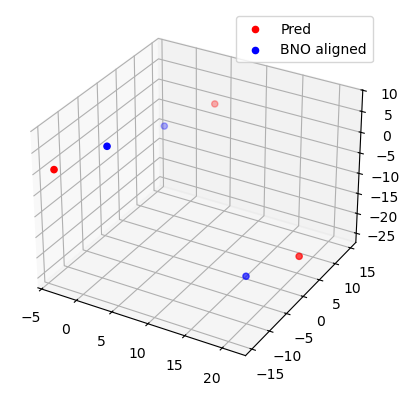

Saved animation to ana_pred_bno_test_orientation_anim.mp4


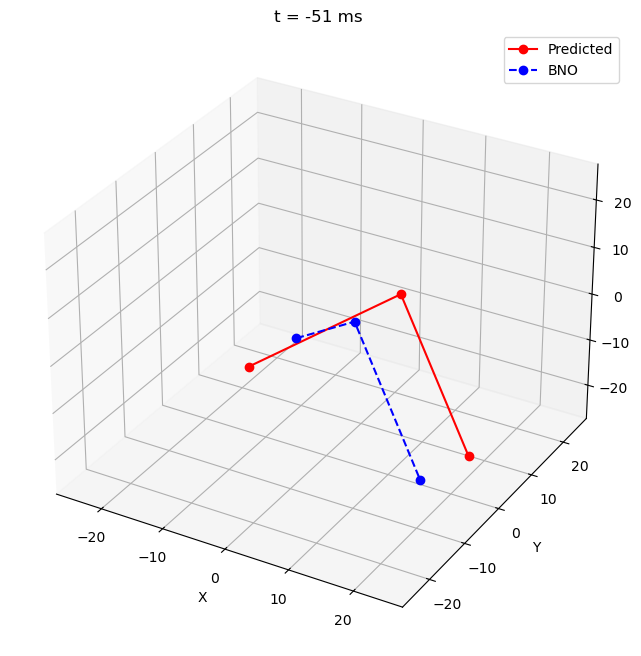

In [1]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pathlib import Path

# --- Load filtered BNO data ---
bno_csv = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13/MIR_Aligned/headOrientation_filtered.csv"
df_bno = pd.read_csv(bno_csv).rename(columns={'Time Stamp (ms)': 'time_ms'})
times = df_bno['time_ms'].to_numpy()
quats = df_bno[['qx','qy','qz','qw']].to_numpy()
rots = R.from_quat(quats)
bno_mats = rots.as_matrix()

print(f"BNO frames: {len(times)}")
print(f"BNO rotation mats shape: {bno_mats.shape}")

# --- Load prediction H5 and compute head frames ---
base_path = "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13"
aligned_dir = Path(base_path) / 'MIR_Aligned'
h5_paths = list(aligned_dir.glob('aligned_predictions_with_ca_and_dF_F_*.h5'))
if not h5_paths:
    raise FileNotFoundError(f"No .h5 files found in {aligned_dir}")
print("H5 files:", h5_paths)

df_pred = pd.read_hdf(str(h5_paths[0]), key='df')
print(f"Predicted frames: {len(df_pred)}")

# --- Compute head rotation matrices ---
def normalize(v):
    n = np.linalg.norm(v, axis=1, keepdims=True)
    return np.where(n < 1e-8, v, v / n)

R_heads = []
for _, row in df_pred.iterrows():
    earL  = row[['kp1_x','kp1_y','kp1_z']].to_numpy()
    earR  = row[['kp2_x','kp2_y','kp2_z']].to_numpy()
    snout = row[['kp3_x','kp3_y','kp3_z']].to_numpy()

    mid = (earL + earR) / 2.0
    x = normalize((snout - mid).reshape(1,3))[0]
    temp = (earR - earL).reshape(1,3)
    y = normalize((temp - np.dot(temp, x) * x).reshape(1,3))[0]
    z = np.cross(x, y)
    z = z / (np.linalg.norm(z) + 1e-8)
    R_heads.append(np.column_stack((x, y, z)))

R_heads = np.stack(R_heads)
print(f"Head rotation mats shape: {R_heads.shape}")

assert R_heads.shape == bno_mats.shape, \
    f"Frame mismatch: pred {R_heads.shape[0]}, bno {bno_mats.shape[0]}"

# --- Precompute relative rotations (correct order) ---
R0_bno = bno_mats[0]
R_bno_rel = np.einsum('ij,nkj->nki', np.linalg.inv(R0_bno), bno_mats)
R0_pred = R_heads[0]
R_pred_rel = np.einsum('ij,nkj->nki', np.linalg.inv(R0_pred), R_heads)

# --- Initial triangle vertices (relative) ---
earL0 = df_pred.iloc[0][['kp1_x','kp1_y','kp1_z']].to_numpy()
earR0 = df_pred.iloc[0][['kp2_x','kp2_y','kp2_z']].to_numpy()
sn0   = df_pred.iloc[0][['kp3_x','kp3_y','kp3_z']].to_numpy()
mid0  = (earL0 + earR0) / 2.0
verts0 = np.vstack([earL0-mid0, earR0-mid0, sn0-mid0])

# --- Frame 0 sanity check ---
p0 = verts0 @ R_pred_rel[0].T
b0 = verts0 @ R_bno_rel[0].T

print("Frame 0 pred pts:\n", p0)
print("Frame 0 bno pts:\n", b0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p0[:,0], p0[:,1], p0[:,2], c='r', label='Pred')
ax.scatter(b0[:,0], b0[:,1], b0[:,2], c='b', label='BNO')
ax.legend()
plt.show()

# --- Compute and apply the “fit” rotation to BNO at frame 0 ---
# This matches b0 → p0 with essentially zero RMSD.
rot_fit, rmsd = R.align_vectors(p0, b0)
R_fit_mat = rot_fit.as_matrix()
print(f"RMSD after alignment: {rmsd}")
print("Alignment rotation matrix:\n", R_fit_mat)

# Pre-rotate your BNO‐triangle basis
verts0_bno = verts0 @ R_fit_mat.T

# Verify the new Frame 0 overlay
b0_aligned = verts0_bno @ R_bno_rel[0].T
print("Frame 0 BNO pts after pre-rotation:\n", b0_aligned)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p0[:,0], p0[:,1], p0[:,2], c='r', label='Pred')
ax.scatter(b0_aligned[:,0], b0_aligned[:,1], b0_aligned[:,2], c='b', label='BNO aligned')
ax.legend()
plt.show()

# --- Determine plot limits dynamically based on initial (aligned) frame ---
all0 = np.vstack([p0, b0_aligned])
lim = np.max(np.abs(all0)) * 1.1

# --- Set up animation ---
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)
ax2.set_zlim(-lim, lim)
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
pred_line, = ax2.plot([], [], [], 'r-o', label='Predicted')
bno_line,  = ax2.plot([], [], [], 'b--o', label='BNO')
ax2.legend()

def update(i):
    p_pts = verts0 @ R_pred_rel[i].T
    b_pts = verts0_bno @ R_bno_rel[i].T   # <— use the pre-rotated basis here

    pred_line.set_data(p_pts[:,0], p_pts[:,1])
    pred_line.set_3d_properties(p_pts[:,2])

    bno_line.set_data(b_pts[:,0], b_pts[:,1])
    bno_line.set_3d_properties(b_pts[:,2])

    ax2.set_title(f"t = {times[i]} ms")
    return pred_line, bno_line

ani = FuncAnimation(fig2, update, frames=len(times), interval=50, blit=False)

# --- Save animation (mp4, fallback to GIF) ---
output_mp4 = "ana_pred_bno_test_orientation_anim.mp4"
try:
    ani.save(output_mp4, writer='ffmpeg', fps=10)
    print("Saved animation to", output_mp4)
except Exception as e:
    print("ffmpeg save failed:", e)
    try:
        output_gif = "ana_pred_bno_test_orientation_anim.gif"
        ani.save(output_gif, writer='pillow', fps=10)
        print("Saved animation to", output_gif)
    except Exception as e2:
        print("Pillow save failed:", e2)



In [2]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import matplotlib.pyplot as plt

# Compute the rotation that maps Pred → BNO at each frame
# R_err[n] = R_pred_rel[n].T @ R_bno_rel[n]
R_err = np.einsum('nij,njk->nik',
                  np.linalg.inv(R_pred_rel),  # R_pred_rel[n].T
                  R_bno_rel)

# Convert to Rotation objects and get the rotation magnitude (in radians)
rots_err = R.from_matrix(R_err)
ang_err_rad = rots_err.magnitude()         # shape (N,)
ang_err_deg = np.degrees(ang_err_rad)      # convert to degrees


In [3]:
print(f"Angular error (deg): mean={ang_err_deg.mean():.2f}, "
      f"median={np.median(ang_err_deg):.2f}, std={ang_err_deg.std():.2f}, "
      f"max={ang_err_deg.max():.2f}")

# Fraction of frames under, say, 5°:
thr = 5.0
pct_under = 100 * np.mean(ang_err_deg < thr)
print(f"Frames < {thr}°: {pct_under:.1f}%")


Angular error (deg): mean=53.08, median=50.84, std=14.92, max=178.31
Frames < 5.0°: 0.0%


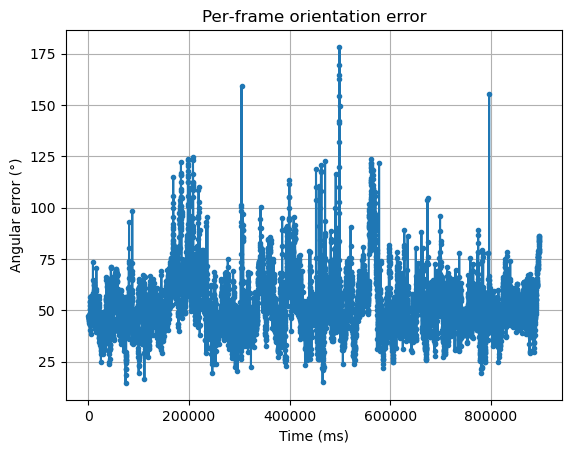

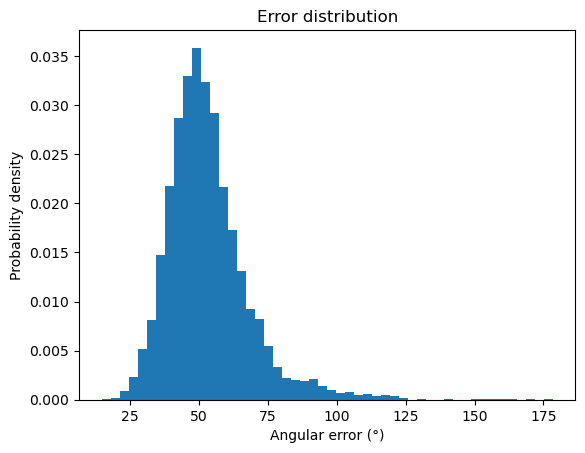

In [4]:
# Time-series
plt.figure()
plt.plot(times, ang_err_deg, '.-')
plt.xlabel('Time (ms)')
plt.ylabel('Angular error (°)')
plt.title('Per‐frame orientation error')
plt.grid(True)
plt.show()

# Histogram
plt.figure()
plt.hist(ang_err_deg, bins=50, density=True)
plt.xlabel('Angular error (°)')
plt.ylabel('Probability density')
plt.title('Error distribution')
plt.show()


In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Define original axes
x = np.array([1, 0, 0])
y = np.array([0, 1, 0])
z = np.array([0, 0, 1])

# Define a rotation: 90 deg about Z
rot = R.from_euler('z', 90, degrees=True)
R_mat = rot.as_matrix()
print("Rotation matrix:\n", R_mat)

# Apply to axes
print("New X-axis:", R_mat @ x)
print("New Y-axis:", R_mat @ y)
print("New Z-axis:", R_mat @ z)


Rotation matrix:
 [[ 2.22044605e-16 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  2.22044605e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
New X-axis: [2.22044605e-16 1.00000000e+00 0.00000000e+00]
New Y-axis: [-1.00000000e+00  2.22044605e-16  0.00000000e+00]
New Z-axis: [0. 0. 1.]


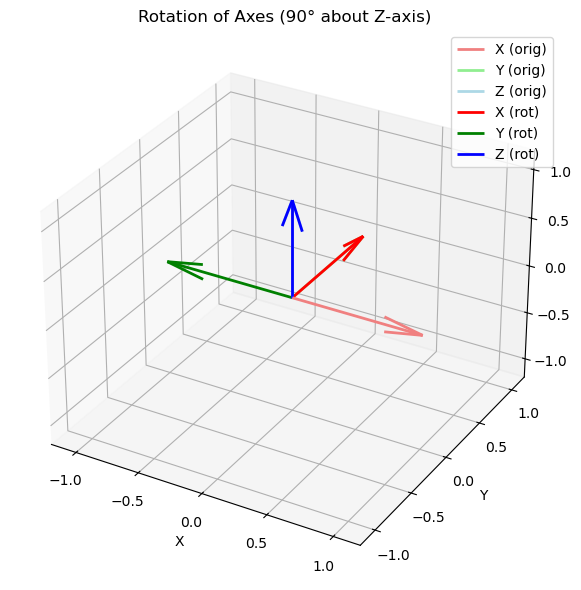

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define original coordinate axes
x = np.array([1, 0, 0])
y = np.array([0, 1, 0])
z = np.array([0, 0, 1])

# Define a rotation: 90° about Z-axis
rot = R.from_euler('z', 90, degrees=True)
R_mat = rot.as_matrix()

# Rotate axes
x_rot = R_mat @ x
y_rot = R_mat @ y
z_rot = R_mat @ z

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Original axes (in light colors)
ax.quiver(0, 0, 0, x[0], x[1], x[2], color='lightcoral', label='X (orig)', linewidth=2)
ax.quiver(0, 0, 0, y[0], y[1], y[2], color='lightgreen', label='Y (orig)', linewidth=2)
ax.quiver(0, 0, 0, z[0], z[1], z[2], color='lightblue', label='Z (orig)', linewidth=2)

# Rotated axes (in darker colors)
ax.quiver(0, 0, 0, x_rot[0], x_rot[1], x_rot[2], color='red', label='X (rot)', linewidth=2)
ax.quiver(0, 0, 0, y_rot[0], y_rot[1], y_rot[2], color='green', label='Y (rot)', linewidth=2)
ax.quiver(0, 0, 0, z_rot[0], z_rot[1], z_rot[2], color='blue', label='Z (rot)', linewidth=2)

# Axis setup
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])
ax.set_xlabel('X')
ax.set_ylabel('Y')1
ax.set_zlabel('Z')
ax.set_title('Rotation of Axes (90° about Z-axis)')
ax.legend()

plt.tight_layout()
plt.show()
